# Fox Hills Park Transportation Barrier Map

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# for interactive webmaps
import folium

In [2]:
latlon = [33.98360403257549, -118.38582269466457] # Already Centered on a good park in District 2 according to our metrics
network_type = 'walk' # Change network type because I am focusing on transportation
trip_times = [5, 10, 15, 20] #in minutes, 
meters_per_minute = 75 # travel distance per minute for a car going 25 mph

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000) # standard

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13181063.964202328
4024198.6859789765
-13176235.047143158
4029015.1368789948


In [7]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13178649.505672742
4026606.9114289857


In [8]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x) # Defining this for later, just as the park center

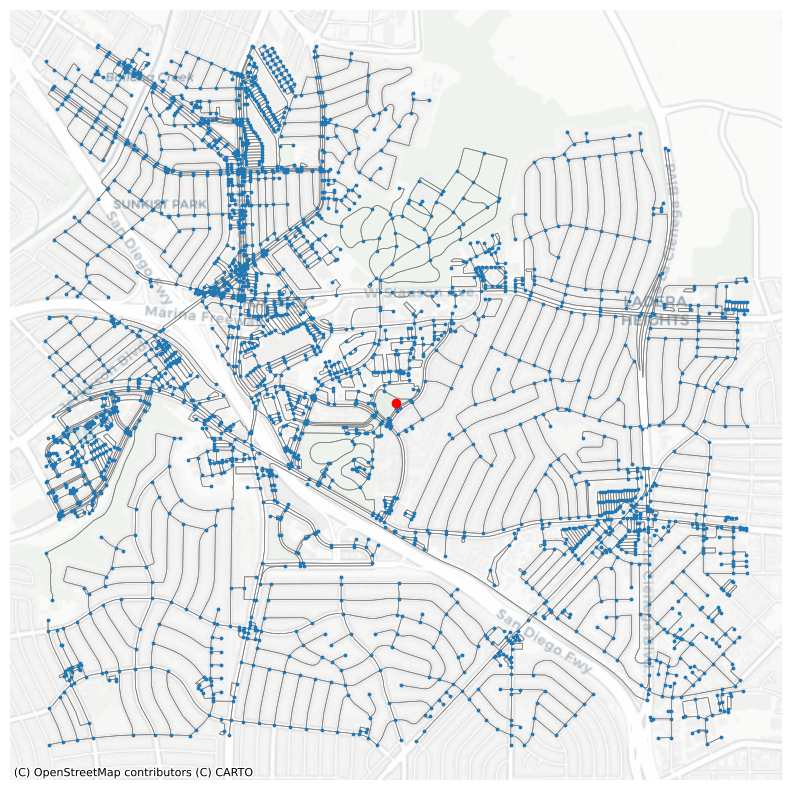

In [9]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5, # don't do more than 1
               edgecolor='gray', # line color
               zorder=10) #3D position (layers)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=3, 
               zorder=20) #this is higher so goes over the lines

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30) # top-most layers

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

# post note: that worked out well because the centroid is focused on the parking lot entrance to the park, where Walkrs would access it. 

In [10]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [11]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(15)

osmid                 name  \
u           v           key                                               
307150853   307150844   0                 56181716                  NaN   
4149954288  122387966   1    [49286490, 413730502]  La Tijera Boulevard   
7911770707  7911770704  0                847854848                  NaN   
7825010200  9176988554  0                838434445                  NaN   
8448926030  8448926029  0                909949529                  NaN   
123053385   123053383   0                 13362227        Glenway Drive   
122864011   307150825   0                165880103      Juniette Street   
10827689536 10827689538 0               1164233731                  NaN   
5697721169  5697721174  0                598654991                  NaN   
8737595474  8737595479  0                943698001                  NaN   
8547935900  8547935904  0                920635398                  NaN   
9088353742  6464197905  0                689103095                  NaN   
5549280721  5549280739  0                579429942                  NaN   
122657834   122798578   0                 13316498       Wynkoop Street   
3694099563  3694092764  0                365395667                  NaN   

                                 highway   length  walk_time  
u           v           key                                   
307150853   307150844   0        service   96.228   1.283040  
4149954288  122387966   1      secondary   59.274   0.790320  
7911770707  7911770704  0        service   82.887   1.105160  
7825010200  9176988554  0        service   13.587   0.181160  
8448926030  8448926029  0        service   17.896   0.238613  
123053385   123053383   0    residential   67.074   0.894320  
122864011   307150825   0    residential  247.408   3.298773  
10827689536 10827689538 0        footway   70.717   0.942893  
5697721169  5697721174  0        footway   56.877   0.758360  
8737595474  8737595479  0        footway    8.642   0.115227  
8547935900  8547935904  0        footway    2.275   0.030333  
9088353742  6464197905  0        service   44.508   0.593440  
5549280721  5549280739  0        service   21.050   0.280667  
122657834   122798578   0    residential  270.789   3.610520  
3694099563  3694092764  0        service  146.462   1.952827

## I get it now.
It took me a while to understand this but I get it. The Walk_time is a function of the length of the edges, not the time to get to the centroid. I have to say it again so I don't forget.

In [12]:
cmap = 'RdYlGn_r'

In [13]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15, 20]
['#006837', '#b7e075', '#fdbf6f', '#a50026']


In [14]:
iso_colors.reverse()
iso_colors

['#a50026', '#fdbf6f', '#b7e075', '#006837']

In [15]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#a50026'), (10, '#fdbf6f'), (15, '#b7e075'), (20, '#006837')]

In [16]:
for time,color in list(time_color):
    print('The color for a '+str(time)+' minute Walk is ' + color) # change this a tiny bit for grammer

The color for a 5 minute Walk is #a50026
The color for a 10 minute Walk is #fdbf6f
The color for a 15 minute Walk is #b7e075
The color for a 20 minute Walk is #006837


In [17]:
time_color.reverse()
time_color

[(20, '#006837'), (15, '#b7e075'), (10, '#fdbf6f'), (5, '#a50026')]

In [18]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time') #centernode is the park, defined earlier 

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' a minute Walk ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 872 nodes within 20 a minute Walk #006837
There are 475 nodes within 15 a minute Walk #b7e075
There are 138 nodes within 10 a minute Walk #fdbf6f
There are 27 nodes within 5 a minute Walk #a50026


In [19]:
gdf_nodes.sample(10)

y             x         highway  street_count  \
osmid                                                                   
7279023522   4.024499e+06 -1.317977e+07             NaN             3   
611822814    4.024611e+06 -1.317862e+07  turning_circle             1   
9176988542   4.028005e+06 -1.317969e+07        crossing             4   
8873838975   4.024621e+06 -1.317975e+07             NaN             3   
9215754767   4.026913e+06 -1.317921e+07             NaN             1   
4682811071   4.028871e+06 -1.317964e+07             NaN             3   
10943804954  4.028590e+06 -1.318021e+07             NaN             1   
123061107    4.024526e+06 -1.317675e+07             NaN             3   
10827689457  4.026356e+06 -1.317881e+07             NaN             3   
2707561986   4.026568e+06 -1.317855e+07             NaN             4   

                    lon        lat                           geometry  time  \
osmid                                                                         
7279023522  -118.395893  33.967948  POINT (-13179770.510 4024499.064)   NaN   
611822814   -118.385531  33.968779  POINT (-13178616.995 4024610.646)   NaN   
9176988542  -118.395194  33.994067  POINT (-13179692.686 4028005.397)   NaN   
8873838975  -118.395671  33.968858  POINT (-13179745.763 4024621.209)   NaN   
9215754767  -118.390901  33.985930  POINT (-13179214.814 4026912.872)  15.0   
4682811071  -118.394681  34.000515  POINT (-13179635.557 4028871.245)   NaN   
10943804954 -118.399877  33.998420  POINT (-13180214.062 4028589.846)   NaN   
123061107   -118.368793  33.968150  POINT (-13176753.763 4024526.137)   NaN   
10827689457 -118.387259  33.981780  POINT (-13178809.433 4026355.734)  10.0   
2707561986  -118.384915  33.983358  POINT (-13178548.444 4026567.577)   5.0   

               color  
osmid                 
7279023522       nan  
611822814        nan  
9176988542       nan  
8873838975       nan  
9215754767   #b7e075  
4682811071       nan  
10943804954      nan  
123061107        nan  
10827689457  #fdbf6f  
2707561986   #a50026

In [20]:
import numpy as np
gdf_nodes['color'] = gdf_nodes['color'].replace('nan', np.nan)
gdf_nodes = gdf_nodes.dropna(subset=['color'])
gdf_nodes

y             x          highway  street_count  \
osmid                                                                    
21306038     4.027168e+06 -1.317688e+07         crossing             3   
3874306342   4.027168e+06 -1.317689e+07  traffic_signals             4   
243778226    4.027150e+06 -1.317657e+07  traffic_signals             4   
5767587554   4.027259e+06 -1.317686e+07              NaN             1   
7916701895   4.027079e+06 -1.317974e+07              NaN             3   
...                   ...           ...              ...           ...   
11717607214  4.026136e+06 -1.317939e+07              NaN             1   
11717607225  4.026410e+06 -1.317927e+07              NaN             3   
11717607235  4.026453e+06 -1.317880e+07              NaN             3   
11717607273  4.026002e+06 -1.317917e+07              NaN             3   
11717607276  4.026051e+06 -1.317915e+07              NaN             1   

                    lon        lat                           geometry  time  \
osmid                                                                         
21306038    -118.369903  33.987827  POINT (-13176877.327 4027167.660)  15.0   
3874306342  -118.369999  33.987831  POINT (-13176888.025 4027168.184)  15.0   
243778226   -118.367154  33.987699  POINT (-13176571.310 4027150.435)  20.0   
5767587554  -118.369745  33.988510  POINT (-13176859.794 4027259.277)  20.0   
7916701895  -118.395580  33.987168  POINT (-13179735.700 4027079.172)  20.0   
...                 ...        ...                                ...   ...   
11717607214 -118.392519  33.980139  POINT (-13179394.895 4026135.544)  15.0   
11717607225 -118.391373  33.982181  POINT (-13179267.390 4026409.634)  10.0   
11717607235 -118.387165  33.982507  POINT (-13178798.980 4026453.399)  10.0   
11717607273 -118.390512  33.979146  POINT (-13179171.555 4026002.241)  15.0   
11717607276 -118.390284  33.979511  POINT (-13179146.096 4026051.159)  15.0   

               color  
osmid                 
21306038     #b7e075  
3874306342   #b7e075  
243778226    #006837  
5767587554   #006837  
7916701895   #006837  
...              ...  
11717607214  #b7e075  
11717607225  #fdbf6f  
11717607235  #fdbf6f  
11717607273  #b7e075  
11717607276  #b7e075  

[872 rows x 9 columns]

In [21]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones
# make the polygons by the time intervals

geometry             y  \
time                                                                    
5.0   MULTIPOINT ((-13178814.119 4026552.219), (-131...  4.026412e+06   
10.0  MULTIPOINT ((-13179348.475 4026444.042), (-131...  4.025795e+06   
15.0  MULTIPOINT ((-13179721.696 4026734.450), (-131...  4.027168e+06   
20.0  MULTIPOINT ((-13180111.682 4026557.978), (-131...  4.027150e+06   

                 x          highway  street_count         lon        lat  \
time                                                                       
5.0  -1.317869e+07  traffic_signals             4 -118.386181  33.982202   
10.0 -1.317870e+07         crossing             3 -118.386240  33.977600   
15.0 -1.317688e+07         crossing             3 -118.369903  33.987827   
20.0 -1.317657e+07  traffic_signals             4 -118.367154  33.987699   

        color  
time           
5.0   #a50026  
10.0  #fdbf6f  
15.0  #b7e075  
20.0  #006837

In [22]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones
# make the polygon outta the nodes

time                                           geometry
0   5.0  POLYGON ((-13178689.341 4026412.480, -13178704...
1  10.0  POLYGON ((-13178695.965 4025794.596, -13178708...
2  15.0  POLYGON ((-13178312.948 4025496.842, -13178455...
3  20.0  POLYGON ((-13177973.223 4025301.489, -13179583...

In [23]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones.rename(columns={'time': 'Walk Time (min)'}, inplace=True)
isochrones

Walk Time (min)                                           geometry
3             20.0  POLYGON ((-13177973.223 4025301.489, -13179583...
2             15.0  POLYGON ((-13178312.948 4025496.842, -13178455...
1             10.0  POLYGON ((-13178695.965 4025794.596, -13178708...
0              5.0  POLYGON ((-13178689.341 4026412.480, -13178704...

# Add in other datasets

In [24]:
import pandas as pd 
import geopandas as gpd

In [25]:
Income = pd.read_excel(
    'Data/Income-Data.xlsx',
    dtype=
    {
        'GEO_ID':str,
    }
)
Income = Income.drop([0])
Income.info

<bound method DataFrame.info of       Geometry       GEO_ID  Less_10k  10k_to_14999  15k_to_19999  20k_24999  \
1     1400000U  06037101110        54           126            49         33   
2     1400000U  06037101122        88             0             7         42   
3     1400000U  06037101220        78            82            28        102   
4     1400000U  06037101221        76           107           118        148   
5     1400000U  06037101222       161           167            34         41   
...        ...          ...       ...           ...           ...        ...   
2494  1400000U  06037980038         0             0             0          0   
2495  1400000U  06037980039         0             0             0          0   
2496  1400000U  06037990100         0             0             0          0   
2497  1400000U  06037990200         0             0             0          0   
2498  1400000U  06037990300         0             0             0          0   

      2

In [26]:
Tracts = gpd.read_file('Data/tl_2021_06_tract.zip')

Tracts1 = Tracts[['GEOID','geometry']]
Tracts1.columns = ['GEO_ID',
'geometry']
Tracts1.head()

GEO_ID                                           geometry
0  06085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1  06085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2  06085507003  POLYGON ((-122.02489 37.21683, -122.02459 37.2...
3  06085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4  06085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...

In [27]:
District2 = pd.read_excel('Data/District2.xlsx',
    dtype =
    {
        'CT20':str,
    }
)
District2['GEO_ID'] = '06' + '037' + District2['CT20']
District2.head()

OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0          640           2         640  211000  2110.00  2ND SUP. DISTRICT   
1          641           2         641  211121  2111.21  2ND SUP. DISTRICT   
2          642           3         642  211122  2111.22  2ND SUP. DISTRICT   
3          643           2         643  211123  2111.23  2ND SUP. DISTRICT   
4          644           2         644  211124  2111.24  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF NAME_1  \
0  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
1  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
2  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
3  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
4  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   

        JURISDICTION  AREA_NUM               AREA_NAME   Shape__Area  \
0  INCORPORATED CITY         5  Westside Planning Area  3.881413e+06   
1  INCORPORATED CITY         9     Metro Planning Area  3.125745e+05   
2  INCORPORATED CITY         9     Metro Planning Area  5.341218e+05   
3  INCORPORATED CITY         9     Metro Planning Area  2.513022e+05   
4  INCORPORATED CITY         9     Metro Planning Area  5.771177e+05   

   Shape__Length       GEO_ID  
0    9270.888577  06037211000  
1    2799.117227  06037211121  
2    3050.487937  06037211122  
3    2501.035059  06037211123  
4    3012.923477  06037211124

In [28]:
District2Tracts=Tracts1.merge(District2,on="GEO_ID")
District2Tracts.head()

GEO_ID                                           geometry  \
0  06037541605  POLYGON ((-118.21630 33.90339, -118.21538 33.9...   
1  06037542000  POLYGON ((-118.20734 33.90732, -118.20733 33.9...   
2  06037542401  POLYGON ((-118.21998 33.89600, -118.21985 33.8...   
3  06037542402  POLYGON ((-118.21883 33.88859, -118.21868 33.8...   
4  06037542502  POLYGON ((-118.23599 33.89591, -118.23571 33.8...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1791           1        1791  541605  5416.05  2ND SUP. DISTRICT   
1         1796           2        1796  542000  5420.00  2ND SUP. DISTRICT   
2         1802           1        1802  542401  5424.01  2ND SUP. DISTRICT   
3         1803           2        1803  542402  5424.02  2ND SUP. DISTRICT   
4         1805           1        1805  542502  5425.02  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF                 NAME_1  \
0  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
1  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON  EAST RANCHO DOMINGUEZ   
2  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
3  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
4  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   

                  JURISDICTION  AREA_NUM            AREA_NAME   Shape__Area  \
0            INCORPORATED CITY         9  Metro Planning Area  1.270111e+06   
1  INCORPORATED/UNINCORPORATED         9  Metro Planning Area  1.417641e+06   
2            INCORPORATED CITY         9  Metro Planning Area  1.881859e+06   
3            INCORPORATED CITY         9  Metro Planning Area  2.423799e+06   
4            INCORPORATED CITY         9  Metro Planning Area  1.447622e+06   

   Shape__Length  
0    5153.474133  
1    5127.847215  
2    5783.777118  
3    8444.461398  
4    5218.654088

In [29]:
District2TractsGEO=District2Tracts.merge(Income,on="GEO_ID")
District2TractsGEO.head()

GEO_ID                                           geometry  \
0  06037541605  POLYGON ((-118.21630 33.90339, -118.21538 33.9...   
1  06037542000  POLYGON ((-118.20734 33.90732, -118.20733 33.9...   
2  06037542401  POLYGON ((-118.21998 33.89600, -118.21985 33.8...   
3  06037542402  POLYGON ((-118.21883 33.88859, -118.21868 33.8...   
4  06037542502  POLYGON ((-118.23599 33.89591, -118.23571 33.8...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1791           1        1791  541605  5416.05  2ND SUP. DISTRICT   
1         1796           2        1796  542000  5420.00  2ND SUP. DISTRICT   
2         1802           1        1802  542401  5424.01  2ND SUP. DISTRICT   
3         1803           2        1803  542402  5424.02  2ND SUP. DISTRICT   
4         1805           1        1805  542502  5425.02  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP  ... 35k_39999 40k_to_44999  \
0  2ND DISTRICT: HOLLY MITCHELL         2  ...       101           91   
1  2ND DISTRICT: HOLLY MITCHELL         2  ...        13           55   
2  2ND DISTRICT: HOLLY MITCHELL         2  ...        21           69   
3  2ND DISTRICT: HOLLY MITCHELL         2  ...        47           74   
4  2ND DISTRICT: HOLLY MITCHELL         2  ...        51           87   

  45k_to_49999  50k_to_59999 60k_to_74999  75k_to_99999  100k_to_124999  \
0           32           251           92           186             153   
1           72           119          146           289              32   
2           54           142          106           215             179   
3           17            46          149           135             118   
4           57            30          211           238              50   

  125k_to_149999  150k_to_199999  200k_plus  
0             98              11         27  
1             99             120         33  
2             63              21         38  
3            142              45         11  
4             10              57         10  

[5 rows x 34 columns]

In [30]:
VulnerableCar = pd.read_excel('Data/Transport.xlsx',
 dtype =
    {
        'TRACT':str,
    }
)
VulnerableCar['GEO_ID'] = '06' + '037' + VulnerableCar['TRACT']
VulnerableCar.head()

TRACT  D2_Transp    atmbl_p       GEO_ID
0  101110          2  53.753368  06037101110
1  101122          1  98.986270  06037101122
2  101210          1  28.538432  06037101210
3  101220          2  16.745798  06037101220
4  101300          2  59.707430  06037101300

In [31]:
District2VulnerableCar=District2TractsGEO.merge(VulnerableCar,on="GEO_ID")
District2VulnerableCar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   GEO_ID          407 non-null    object  
 1   geometry        407 non-null    geometry
 2   OBJECTID_12     407 non-null    int64   
 3   Join_Count      407 non-null    int64   
 4   TARGET_FID      407 non-null    int64   
 5   CT20            407 non-null    object  
 6   LABEL           407 non-null    float64 
 7   NAME            407 non-null    object  
 8   SUP_NAME        407 non-null    object  
 9   DIST_SUP        407 non-null    int64   
 10  CITYNAME_ALF    361 non-null    object  
 11  NAME_1          55 non-null     object  
 12  JURISDICTION    407 non-null    object  
 13  AREA_NUM        407 non-null    int64   
 14  AREA_NAME       407 non-null    object  
 15  Shape__Area     407 non-null    float64 
 16  Shape__Length   407 non-null    float64 
 17  Geometry

In [32]:
m = folium.Map(location=latlon,zoom_start=13, tiles='Cartodb Positron')

# Map it based on D2_Transp
folium.Choropleth(
    geo_data=District2VulnerableCar,
    data=District2VulnerableCar,
    key_on='feature.properties.GEO_ID',
    columns=['GEO_ID','D2_Transp'],
    fill_color='YlOrRd',
    line_weight=0.1, 
    fill_opacity=0.7,
    line_opacity=0.2).add_to(m)  

#Add popups
popup = folium.GeoJsonPopup(
    fields=['D2_Transp','CITYNAME_ALF', 'GEO_ID', 'NAME',],
    aliases=['Number of Transportation Barriers:','City:', 'Census Tract:', 'District:',],
    localize=True,
    sticky=False,
    labels=True,
    style="border:none;", #
)

folium.GeoJson(
    District2VulnerableCar,
    popup=popup,
).add_to(m)

isochrones.explore(m=m,column='Walk Time (min)',color='iso_colors',cmap=cmap,opacity=0.4,categorical=True)

gdf_nodes.explore(m=m,column='time')

title_html = '<h3 align="center" style="font-size:20px"><b>Transportation Barriers overlayed with a 20-minute walking radius around Fox Hills Park in District 2</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

In [33]:
m.save('FoxTransp.html')